# **Order Prepation process simulation**

**Process :**
- Check Availablility -> Checkers
- Packing -> Packing_Employees
- Delivery -> Delivery_Employees

In [35]:
import simpy
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
# import my_statistics as stat
import sys

In [36]:
arrival_times = []
waits_time = []
begin_time = []
end_time = []
last_arrival = []
busy = []
Idle = []

In [37]:
# parametes
no_order_taker = 2
no_chief = 2
no_waiters = 2
num_servers = 3
service_rates = [5, 7, 4]
arrival_rate = 3
simulation_time  = 1000
lambda_for_arrival = 1/6
lambda_for_order = 1/5
lambda_for_cooking = 1/6
lambda_for_serving = 1/5
number_of_customer = 50
RANDOM_SEED = 4232
random.seed(RANDOM_SEED)

In [38]:
class Server:
    def __init__(self, env, server_id, service_rate, capacity=5):
        self.env = env
        self.server_id = server_id
        self.service_rate = service_rate
        self.capacity = capacity
        self.queue = simpy.Store(env, capacity=capacity)
        self.busy_time = 0
        self.served_customers = 0
        self.waiting_time = 0
        self.queue_lengths = []
        self.max_queue_length = 0
        self.isbusy = False
        self.action = env.process(self.run())

    def run(self):
        while True:
            customer = yield self.queue.get()
            self.isbusy = True
            arrival_time = customer[1]
            customer_name = customer[0]

            start_service_time = self.env.now
            self.served_customers += 1
            service_time = random.expovariate(1.0 / self.service_rate)
            self.busy_time += service_time


            wait_time = start_service_time - arrival_time
            self.waiting_time += wait_time


            customer_info = {
                'customer_name': f"customer {customer_name}",
                'arrival_time': arrival_time,
                'start_service_time': start_service_time,
                'end_service_time': start_service_time + service_time,
                'wait_time': wait_time,
                'service_time': service_time,
                "server_name" : f"server {self.server_id}"
            }
            customer_data.append(customer_info)

            yield self.env.timeout(service_time)


            self.queue_lengths.append(len(self.queue.items))
            self.max_queue_length = max(self.max_queue_length, len(self.queue.items))
            self.isbusy = False

    def get_statistics(self, simulation_time):
        utilization = self.busy_time / simulation_time
        average_queue_length = np.mean(list(set(self.queue_lengths)))
        avg_service_time = self.busy_time / self.served_customers
        idle_probability = (simulation_time - self.busy_time) / simulation_time
        ave_wait_time = self.waiting_time / self.served_customers
        return {
            'server_name' : f"server {self.server_id}",
            'utilization': utilization,
            'average_queue_length': average_queue_length,
            'queue_len':list(set(self.queue_lengths)),
            'max_queue_length': self.max_queue_length,
            'served_customers': self.served_customers,
            'average_service_time': avg_service_time,
            'idle_probability': idle_probability,
            'avg_waiting_time': ave_wait_time

        }

In [39]:
def customer_arrivals(env, servers, arrival_rate):
    customer_id = 0
    while True:
        interarrival = random.expovariate(1.0 / arrival_rate)
        yield env.timeout(interarrival)
        sorted(servers, key=lambda s: len(s.queue.items))
        for server in servers:
            if len(server.queue.items) < server.queue.capacity and server.isbusy == False:
                print(f"Time {env.now}: Customer {customer_id} arrives and joins Server {server.server_id}'s queue")
                server.queue.put((customer_id, env.now))
            else:
                print(f"Time {env.now}: Customer {customer_id} arrives but all servers' queue is full! Customer is lost.")

        customer_id += 1

In [40]:
def customer(env, name, order_takers,chiefs, waiters):
    arrival_time = env.now
    print(f"{name} arrives at {arrival_time:.2f}")

    with order_takers.request() as request:
        print(f"{name} starts at {env.now:.2f} to order (Busy: {order_takers.count}/{order_takers.capacity}, Idle: {order_takers.capacity - order_takers.count})")
        print(f"Order takers queue: {order_takers.queue}")
        yield request
        print(f"{name} starts ordering at {env.now:.2f}")
        yield env.timeout(random.expovariate(lambda_for_order))

    with chiefs.request() as chief_request:
        print(f"{name} moves to chiefs at {env.now:.2f} (Busy: {chiefs.count}/{chiefs.capacity}, Idle: {chiefs.capacity - chiefs.count})")
        print(f"Chiefs queue: {chiefs.queue}")
        yield chief_request
        print(f"{name} is being served by chief at {env.now:.2f}")
        yield env.timeout(random.expovariate(lambda_for_cooking))

    with waiters.request() as waiter_request:
        print(f"{name} moves to waiters at {env.now:.2f} (Busy: {waiters.count}/{waiters.capacity}, Idle: {waiters.capacity - waiters.count})")
        print(f"Waiters queue: {waiters.queue}")
        yield waiter_request
        print(f"{name} is being served by waiter at {env.now:.2f}")
        yield env.timeout(random.expovariate(lambda_for_serving))

    print(f"{name} leaves system at {env.now:.2f}")

In [41]:
def generate_customer(env, number_of_customer, order_takers,chiefs, waiters):
    '''
     for number of customer
     wait arrival time and generate customer
     then customer process should trigger
    '''
    for i in range(number_of_customer):
        arrival_time = random.expovariate(lambda_for_arrival)
        yield env.timeout(arrival_time)
        env.process(customer(env, f"customer_{i}",  order_takers,chiefs, waiters))

In [42]:
sys.stdout = open("log3_filename", 'w')
env = simpy.Environment()

order_takers = simpy.Resource(env, capacity=no_order_taker)
chiefs = simpy.Resource(env, capacity=no_chief)
waiters = simpy.Resource(env, capacity=no_waiters)
env.process(generate_customer(env,number_of_customer ,order_takers,chiefs, waiters))

env.run(until=simulation_time)

In [43]:
customer_data = []
server_data = []
sys.stdout = open("log2_filename", 'w')
RANDOM_SEED = 4232
random.seed(RANDOM_SEED)


env = simpy.Environment()
servers = [Server(env, i, service_rates[i]) for i in range(num_servers)]
env.process(customer_arrivals(env, servers, arrival_rate))
env.run(until=simulation_time)

for s in servers:
    server_data.append(s.get_statistics(simulation_time))


C:\Users\x2912\AppData\Local\Temp\ipykernel_4736\1103567521.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i, j].legend()


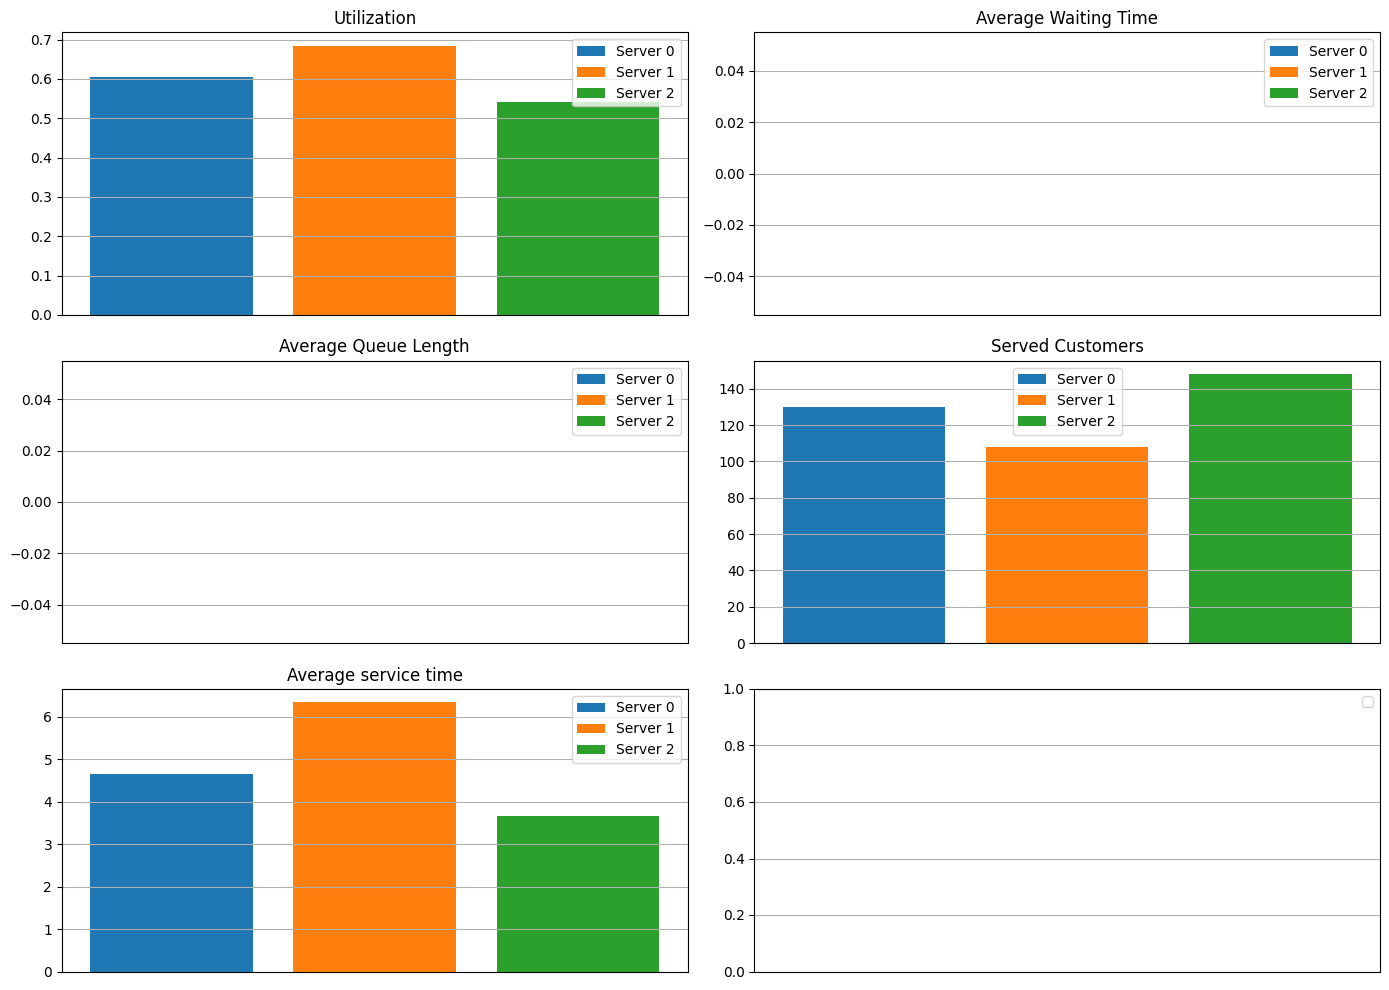

In [44]:
fig, ax = plt.subplots(3, 2, figsize=(14, 10))

for server in servers:
    stats = server.get_statistics(simulation_time)

    ax[0, 0].bar(server.server_id, stats['utilization'], label=f'Server {server.server_id}')

    ax[0, 1].bar(server.server_id, stats['avg_waiting_time'], label=f'Server {server.server_id}')

    ax[1, 0].bar(server.server_id, stats['average_queue_length'], label=f'Server {server.server_id}')

    ax[1, 1].bar(server.server_id, stats['served_customers'], label=f'Server {server.server_id}')
    ax[2, 0].bar(server.server_id, stats['average_service_time'], label=f'Server {server.server_id}')

    ax[0, 0].set_title("Utilization")
    ax[0, 1].set_title("Average Waiting Time")
    ax[1, 0].set_title("Average Queue Length")
    ax[1, 1].set_title("Served Customers")
    ax[2, 0].set_title("Average service time")

    for i in range(3):
        for j in range(2):
            ax[i, j].legend()
            ax[i, j].grid(True)
            ax[i, j].set_xticks([])

plt.tight_layout()
plt.show()